In [1]:
import sys
sys.path.insert(0, '../')
import torch
from models.custom import HorizonModel

model = HorizonModel('../yolos/yolov5n6_RGB_D2304-v1_9C.pt')
[print(m.i, m.f, m.type) for m in model.model]
model.info()

pred = model(torch.zeros(1, 3, 640, 640).to(model.device))
assert pred[0].shape == (1, 500) and pred[1].shape == (1, 500)

YOLOv5 🚀 v7.0-24-g22e72e2 Python-3.10.11 torch-2.1.0 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)

Loaded weights from ../yolos/yolov5n6_RGB_D2304-v1_9C.pt
WARNING ⚠️ converting YOLOv5 DetectionModel to HorizonModel


0 -1 models.common.Conv
1 -1 models.common.Conv
2 -1 models.common.C3
3 -1 models.common.Conv
4 -1 models.common.C3
5 -1 models.common.Conv
6 -1 models.common.C3
7 -1 models.common.Conv
8 -1 models.common.C3
9 -1 models.common.Conv
10 -1 models.common.C3
c_pitch 10 models.common.Classify
c_theta 10 models.common.Classify


Model summary: 147 layers, 3359304 parameters, 1941480 gradients, 4.7 GFLOPs


In [3]:
ckpt = {
    'epoch': 1,
    'best_fitness': 0,
    'model': model,  # deepcopy(de_parallel(model)).half(),
    'ema': None,  # deepcopy(ema.ema).half(),
    'updates': None,
    'optimizer': None,  # optimizer.state_dict(),
    'opt': None,
    'date': None
    }

# Save last, best and delete
torch.save(ckpt, 'ckpt.pt')

In [4]:
model = HorizonModel('ckpt.pt', device='1')
[print(m.i, m.f, m.type) for m in model.model]
model.info()

pred = model(torch.zeros(1, 3, 640, 640).to(model.device))
assert pred[0].shape == (1, 500) and pred[1].shape == (1, 500)

YOLOv5 🚀 v7.0-15-ge8b349c Python-3.10.11 torch-2.0.1 CUDA:1 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)



Model summary: 126 layers, 2823240 parameters, 1941480 gradients, 4.3 GFLOPs


0 -1 models.common.Conv
1 -1 models.common.Conv
2 -1 models.common.C3
3 -1 models.common.Conv
4 -1 models.common.C3
5 -1 models.common.Conv
6 -1 models.common.C3
7 -1 models.common.Conv
8 -1 models.common.C3
c_pitch 8 models.common.Classify
c_theta 8 models.common.Classify


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["FIFTYONE_CONFIG_PATH"] = "/Users/kevinserrano/.fiftyone/config.global_mongodb.json"

In [153]:
import sys

sys.path.insert(0, "../")

import numpy as np
import fiftyone as fo
from fiftyone import ViewField as F
import torch
from PIL import Image

from utils.horizon import draw_horizon
from models.custom import HorizonModel
from horizon.dataloaders import (
    get_train_rgb_dataloader,
    get_val_rgb_dataloader,
    get_train_ir16bit_dataseloader,
    get_val_ir16bit_dataloader,
)

batch_size = 1

dataset_name = "TRAIN_RL_SPLIT_THERMAL_2024_03"
train_tag, val_tag = "TRAIN_per_sequence", "VAL_per_sequence"
imgsz = 640

# dataset_name = "SAILING_DATASET_RGB_2023_10"
# train_tag, val_tag = "TRAIN_v0", "VAL_v0"
# imgsz = 1280

weights = f'../runs/horizon/train/{dataset_name}/best.pt'
model = HorizonModel(weights)

if "RGB" in dataset_name:
    dataloader = get_val_rgb_dataloader(
        dataset=(
            fo.load_dataset(dataset_name)
            .match(F("ground_truth_pl.polylines.closed") == [False])
            .match_tags(val_tag)
            # .match(F("trip") == "Trip_306")
            # .take(5000, seed=51)
        ),
        imgsz=imgsz,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True,
    )
else:
    dataloader = get_val_ir16bit_dataloader(
        dataset=(
            fo.load_dataset(dataset_name)
            # .match(F("metadata.width") == 256)
            .match(F("ground_truth_pl.polylines.closed") == [False])
            .match_tags(val_tag)
        ),
        imgsz=imgsz,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True,
    )

YOLOv5 🚀 47e3d71 Python-3.10.13 torch-2.1.1 CPU

Loaded weights from /Users/kevinserrano/Downloads/yolov5h-IR.pt


target=	tensor([[0.36748, 0.55318]], dtype=torch.float64)
pred_argmax=	[tensor([0.36400]), tensor([0.55200])]
pred_fit=	[0.3641287760856224, 0.5527633131461004]


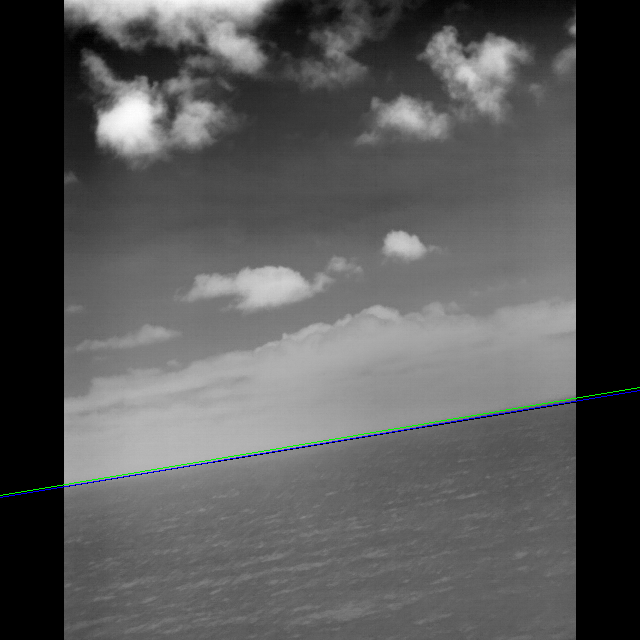

In [154]:
import pandas as pd
import plotly.express as px

for image, target in dataloader:
    break

with torch.no_grad():
    x_pitch, x_theta = model(image.to(model.device))

(y_pitch, score_pitch), (y_theta, score_theta) = model.postprocess(x_pitch, x_theta)
(mu_pitch, amp_pitch, sigma_pitch), (mu_theta, amp_theta, sigma_theta) = (
    model.postprocess_curve_fit(x_pitch, x_theta)
)

print(f"target=\t{target}")
print(f"pred_argmax=\t{[y_pitch, y_theta]}")
print(f"pred_fit=\t{[mu_pitch, mu_theta]}")


# plotting
def gaussian(x, amplitude, mu, sigma):
    return amplitude * np.exp(-((x - mu) ** 2) / (2 * sigma**2))


x_pitch = x_pitch.squeeze().softmax(-1).cpu().numpy()
x_theta = x_theta.squeeze().softmax(-1).cpu().numpy()
x = np.linspace(0, 1, len(x_pitch), endpoint=False)
x_data = np.linspace(0, 1, 5000, endpoint=False)
df_gauss = pd.DataFrame(
    {
        "x_gauss": x_data,
        "pitch_gauss": gaussian(x_data, amp_pitch, mu_pitch, sigma_pitch),
        "theta_gauss": gaussian(x_data, amp_theta, mu_theta, sigma_theta),
    }
)

fig = px.line(df_gauss, x="x_gauss", y=["pitch_gauss", "theta_gauss"])
fig.add_bar(x=x, y=x_pitch, name="pitch", marker=dict(color="blue", opacity=0.5))
fig.add_bar(x=x, y=x_theta, name="theta", marker=dict(color="red", opacity=0.5))
fig.update_layout(barmode="overlay", title="Horizon Predictions")
# set height and tight layout
fig.update_layout(height=300)  # , margin=dict(l=0, r=0, t=0, b=0))
fig.show()

I = (image[0].permute(1, 2, 0) * 255).numpy().astype(np.uint8)
diameter = 1
I = draw_horizon(
    I, pitch_theta=(target[0][0], target[0][1]), color=(0, 255, 0), diameter=diameter
)
I = draw_horizon(
    I, pitch_theta=(y_pitch[0], y_theta[0]), color=(0, 0, 0), diameter=diameter
)
I = draw_horizon(
    I,
    pitch_theta=(mu_pitch, mu_theta),
    color=(0, 0, 255),
    diameter=diameter,
)
I = Image.fromarray(I)
I  # .reduce(2) if I.width >= 1024 else I